In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import shap
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import optuna
from utils.utils import *

sales = pd.read_excel('cryptopunk_sales.xlsx')
metadata = pd.read_csv('cryptopunk_metadata.csv')
cryptopunks_skin = pd.read_csv('cryptopunks_skin.csv')
floor = pd.read_csv('punk floor.csv')

metadata = metadata.merge(cryptopunks_skin, left_on = 'ID', right_on = 'id')

# there are 1.4k below $30
sales = sales[sales.amount_usd>30]
sales['block_date']= pd.to_datetime(sales.block_date)
sales = sales[sales.block_date> '2021-02-01']

sales = sales[['block_date', 'block_month', 'token_id', 'amount_usd', 'amount_original']]

unique_attributes = set()
attribute_columns = [col for col in metadata.columns if 'Attribute' in col]
for col in attribute_columns:
    unique_attributes.update(metadata[col].dropna().unique())

# Creating dummy variables
for attribute in unique_attributes:
    metadata[attribute] = metadata[attribute_columns].apply(lambda x: attribute in x.values, axis=1).astype(int)

metadata = metadata[pd.Series(metadata.columns)[~pd.Series(metadata.columns).isin(attribute_columns)]]
sales = pd.merge(sales, metadata, left_on = 'token_id', right_on = 'ID')

eth = get_ethereum_price_history()

sales = pd.merge(sales, eth, left_on  = 'block_date', right_on = 'Date')
floor['day'] = pd.to_datetime(floor.day)
sales = sales.merge(floor, left_on = 'block_date', right_on = 'day')

earliest_year = sales['block_date'].dt.year.min()
sales['relative_month_number'] = ((sales['block_date'].dt.year - earliest_year) * 12 + sales['block_date'].dt.month)
sales['relative_month_number'] = sales['relative_month_number'] - 12

sales.head()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


,block_date,block_month,token_id,amount_usd,amount_original,ID,Gender,Category,id,skin,...,Tassle Hat,Clown Eyes Blue,Wild White Hair,Date,Ethereum_Price,Unnamed: 0,day,CP Price,BAYC Price,relative_month_number
0,2022-08-03,2022-08-01,2499,174464.3400,106.00,2499,Male,3,2499,white,...,0,0,0,2022-08-03,1638.378683,2040,2022-08-03,68.7125,76.5,8
1,2022-08-03,2022-08-01,3149,124042.9113,74.69,3149,Female,3,3149,Latino,...,0,0,0,2022-08-03,1638.378683,2040,2022-08-03,68.7125,76.5,8
2,2022-08-03,2022-08-01,6821,131687.0210,78.95,6821,Female,3,6821,Latino,...,0,0,0,2022-08-03,1638.378683,2040,2022-08-03,68.7125,76.5,8
3,2022-08-03,2022-08-01,6507,112743.4650,68.50,6507,Male,2,6507,Black,...,0,1,0,2022-08-03,1638.378683,2040,2022-08-03,68.7125,76.5,8
4,2022-08-03,2022-08-01,9018,140683.9600,86.00,9018,Male,4,9018,Latino,...,0,0,0,2022-08-03,1638.378683,2040,2022-08-03,68.7125,76.5,8


<Axes: >

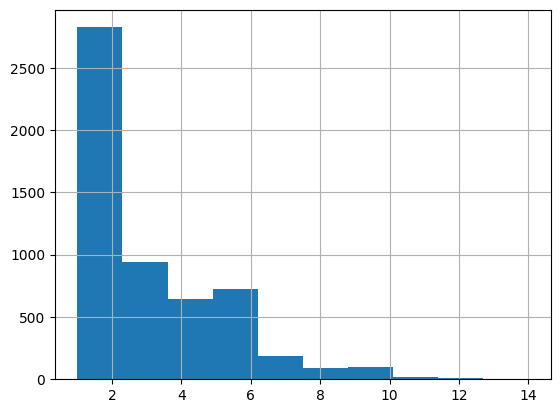

In [13]:
sales.groupby('ID').count().block_date.hist()

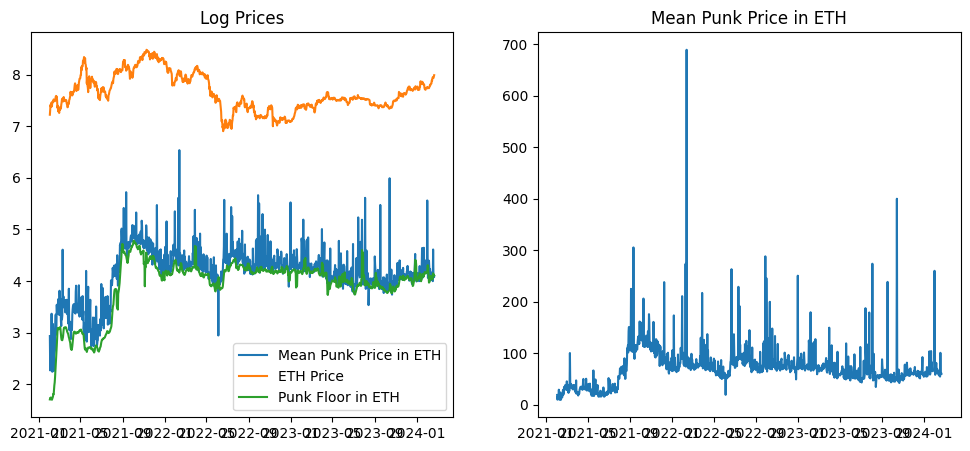

In [2]:
plot_eth_and_punk_prices(sales)

In [6]:
sales = sales[['amount_original', 'CP Price',
       'Gender', 'Category', 'Front Beard Dark', 'VR', 'Clown Eyes Green',
       'Buck Teeth', 'Wild Hair', 'Silver Chain', 'Cigarette',
       'Purple Eye Shadow', 'Pigtails', 'Handlebars', 'Normal Beard',
       'Blonde Bob', 'Muttonchops', 'Smile', 'Shaved Head', 'Mustache',
       'Mohawk Dark', 'Straight Hair', 'Choker', 'Regular Shades',
       'Peak Spike', 'Tassle Hat', 'Dark Hair', 'Knitted Cap', 'Bandana',
       'Pink With Hat', 'Gold Chain', 'Mohawk', 'Welding Goggles',
       'Cap Forward', 'Tiara', 'Purple Lipstick', 'Small Shades',
       'Stringy Hair', 'Do-rag', 'Wild White Hair', 'Frown', 'Red Mohawk',
       'Half Shaved', 'Clown Hair Green', 'Vampire Hair', 'Beanie',
       'Clown Nose', 'Messy Hair', 'Blonde Short', 'Mole', 'Purple Hair',
       'Chinstrap', 'Orange Side', 'Hot Lipstick', 'Horned Rim Glasses', 'Cap',
       'Green Eye Shadow', 'Nerd Glasses', 'Rosy Cheeks', 'Pilot Helmet',
       'Straight Hair Dark', 'Medical Mask', 'Frumpy Hair', 'Wild Blonde',
       'Hoodie', 'Earring', 'Big Shades', 'Spots', 'Headband', 'Goat',
       'Big Beard', 'Classic Shades', 'Clown Eyes Blue', 'Blue Eye Shadow',
       'Cowboy Hat', 'Luxurious Beard', 'Crazy Hair', 'Normal Beard Black',
       'Fedora', 'Straight Hair Blonde', 'Vape', 'Mohawk Thin', 'Front Beard',
       '3D Glasses', 'Police Cap', 'Top Hat', 'Shadow Beard', 'Eye Mask',
       'Black Lipstick', 'Eye Patch', 'Pipe', 'relative_month_number', 'skin']]

to_dummies = ['Gender','skin']#,  'skinColor']# 'year_month', 

for column in to_dummies:
    dummies = pd.get_dummies(sales[column])
    # Generate dummy variables, prefix the original column name to each dummy column
    dummies.columns = [f"{column}_{col}" for col in dummies.columns]
    # Now, `dummies` has column names with both the original column name and the value.
    sales = pd.concat([sales, dummies], axis=1)

for column in to_dummies:
    sales.drop(column, axis=1, inplace=True)

sales = sales.dropna(subset = 'amount_original')

sales.reset_index(inplace=True, drop=True)

X = sales[pd.Series(sales.columns)[pd.Series(sales.columns)!='amount_original'].values]
X = X.drop(['skin_Ape', 'skin_Zombie', 'skin_Alien'], axis=1)
y = sales['amount_original']  # Your target vector

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 486
[LightGBM] [Info] Number of data points in the train set: 13395, number of used features: 97
[LightGBM] [Info] Using GPU Device: GeForce GTX 960, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 7 dense feature groups (0.10 MB) transferred to GPU in 0.001637 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 63.105662
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

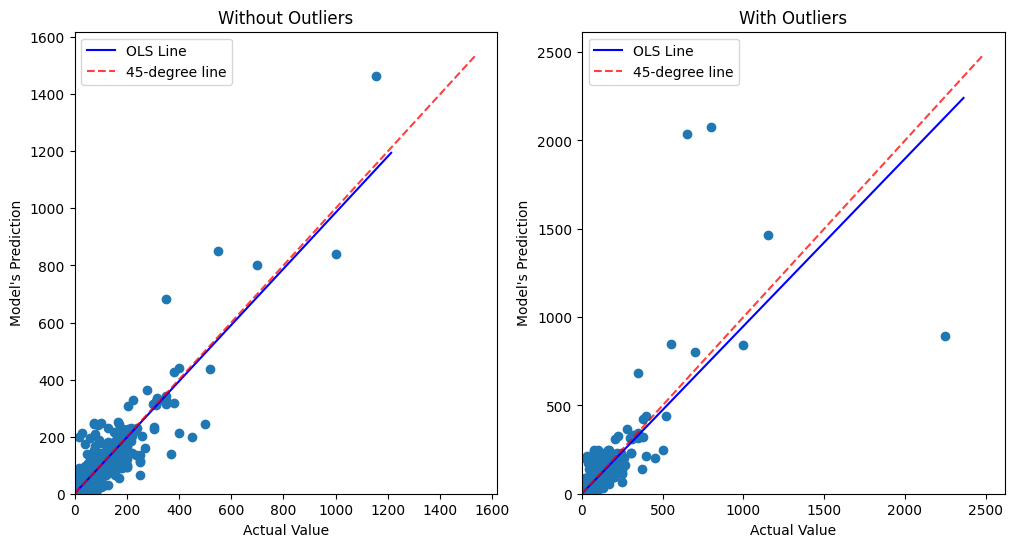

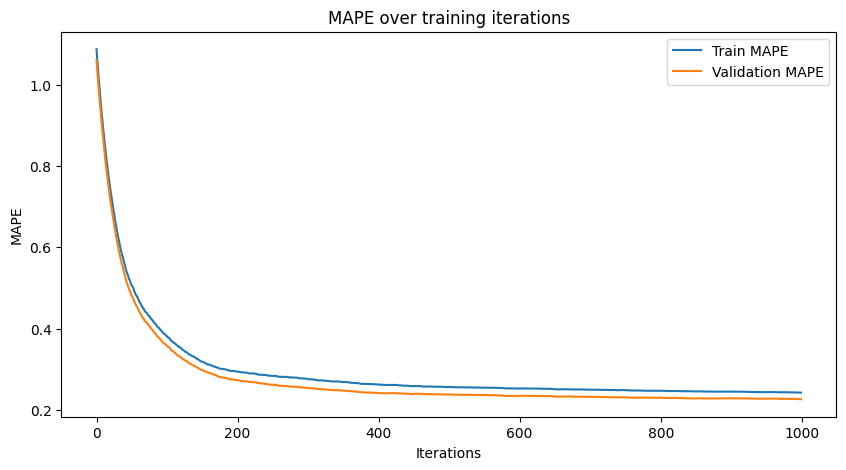

Axes(0.125,0.11;0.775x0.77)


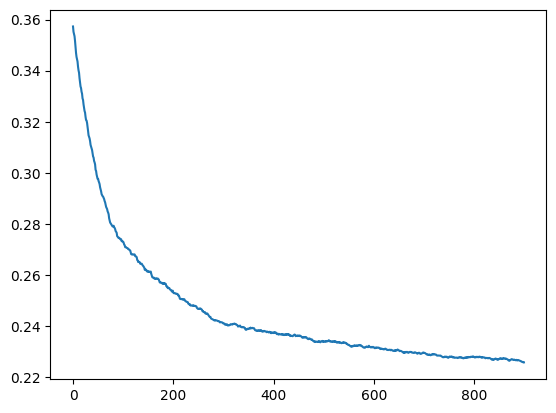

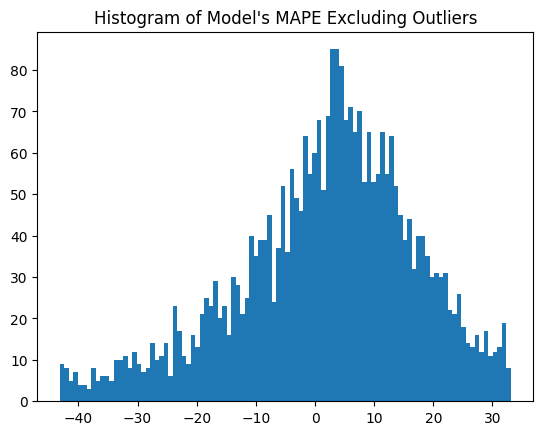

In [7]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = lgb.Dataset(X_train, label=y_train)
dval = lgb.Dataset(X_test, label=y_test, reference=dtrain)

params = {'objective': 'regression',
    'metric': 'mape',
    'device': 'gpu', 'max_depth': 4, 'min_child_weight': 2, 'gamma': 2.96506457602541, 'subsample': 0.6434374753552159, 'colsample_bytree': 0.9312202821412009, 'learning_rate': 0.030685343020770497, 'num_leaves': 100, 'reg_lambda': 3.3667451982299914, 'reg_alpha': 2.3846500834839954}
# params = {'objective': 'regression', 'metric': 'mape', 'device': 'gpu' }

evals={}

bst = lgb.train(params = params, train_set = dtrain, valid_sets=[dtrain, dval], valid_names=['train', 'val'], num_boost_round=1000,
                callbacks=[
                        #lgb.early_stopping(stopping_rounds=300), 
                        lgb.record_evaluation(evals)] )


X_test_eval = X_test.copy()
X_test_eval['y_pred_gb_lgb'] = bst.predict(X_test_eval, num_iteration=bst.best_iteration)
X_test_eval['y_test'] = y_test
X_test_eval['error'] = X_test_eval['y_test'] - X_test_eval['y_pred_gb_lgb']
X_test_eval['perc_error']  = ((1- (X_test_eval['y_test']/X_test_eval['y_pred_gb_lgb']))*100)
X_test_eval['perc_error_abs'] = X_test_eval.perc_error.abs()

print('Mean absolute error in ETH', X_test_eval['error'].abs().mean())
print('MAPE', X_test_eval['perc_error_abs'].mean())

# Create two subplots one with outliers and one without
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

subset_no_outliers = X_test_eval[(X_test_eval['y_test'] < 2000) & (X_test_eval['y_pred_gb_lgb'] < 2000)]
plot_scatter_predictions_and_actuals_with_OLS(axs[0], subset_no_outliers, 'Without Outliers')
plot_scatter_predictions_and_actuals_with_OLS(axs[1], X_test_eval, 'With Outliers')

plt.figure(figsize=(10, 5))
plt.plot(evals['train']['mape'], label='Train MAPE')
plt.plot(evals['val']['mape'], label='Validation MAPE')
plt.xlabel('Iterations')
plt.ylabel('MAPE')
plt.title('MAPE over training iterations')
plt.legend()
plt.show()

print(pd.Series(evals['val']['mape'][100:]).plot())

# Histogram of the error of the model
series_perc_error = exclude_top_and_bottom_5_percent(X_test_eval['perc_error'])
fig, ax = plt.subplots()
counts, bin_edges = np.histogram(series_perc_error, bins=100)
ax.hist(bin_edges[:-1], bin_edges, weights=counts)
ax.set_title('Histogram of Model\'s MAPE Excluding Outliers')
plt.show()

In [45]:
import onnxmltools
from onnxmltools.convert.common.data_types import FloatTensorType
initial_type = [('float_input', FloatTensorType([None, X_train.shape[1]]))]
onnx_model = onnxmltools.convert_lightgbm(bst, initial_types=initial_type)
with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

The maximum opset needed by this model is only 8.


In [ ]:
# this finds the best combination of hyperparameters for light lgb using Optuna

def objective(trial):

    params = {
        'objective': 'regression',    
        'device': 'gpu',
        'metric': 'mape',
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 9),
        'gamma': trial.suggest_float('gamma', 2.5, 5.0),
        'subsample': trial.suggest_float('subsample', 0.55, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 40, 120),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.5, 5, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 2, 5)
    }

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    dtrain = lgb.Dataset(X_train[pd.Series(X_train.columns)[~pd.Series(X_train.columns).isin(['numberId', 'year_month'])].values], label=y_train)
    dval = lgb.Dataset(X_test[pd.Series(X_test.columns)[~pd.Series(X_test.columns).isin(['numberId', 'year_month'])].values], label=y_test, reference=dtrain)
    

    evals={}
    
    bst = lgb.train(params = params, train_set = dtrain, valid_sets=[dtrain, dval], valid_names=['train', 'val'],
                    num_boost_round=1000,
                    callbacks=[
                        #lgb.early_stopping(stopping_rounds=300), 
                        lgb.record_evaluation(evals)] )
    
    # Since scores are negative, take the absolute to get positive RMSE values
    
    X_test['y_pred_gb_lgb'] = bst.predict(X_test[pd.Series(X_test.columns)[~pd.Series(X_test.columns).isin(['numberId', 'year_month'])].values], num_iteration=bst.best_iteration)
    X_test['y_test'] = y_test
    X_test['y_pred_gb_lgb'] = np.maximum(0, X_test['y_pred_gb_lgb'])
    X_test['error'] = X_test['y_test'] - X_test['y_pred_gb_lgb']
    X_test['perc_error']  = ((1- (X_test['y_test']/X_test['y_pred_gb_lgb']))*100)
    X_test['perc_error_abs'] = X_test.perc_error.abs()
    X_test[X_test['perc_error']>-299.99].perc_error.hist(bins=10)

    print(X_test[X_test['perc_error']>-299.99].perc_error.abs().mean())

    print(X_test['error'].abs().mean())
    

    plt.figure(figsize=(10, 5))
    plt.plot(evals['train']['mape'], label='Train MAPE')
    plt.plot(evals['val']['mape'], label='Validation MAPE')
    plt.xlabel('Iterations')
    plt.ylabel('MAPE')
    plt.title('MAPE over training iterations')
    plt.legend()
    plt.show()
    print(pd.Series(evals['val']['mape'][100:]).plot())
    return X_test[X_test['perc_error']>-299.99].perc_error.abs().mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_trial.params
print(f"Best params: {best_params}")

results_df_xgb = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))

plt.figure(figsize=(10, 6))  # Width=10 inches, Height=6 inches
ax = results_df_xgb.value.plot.hist(density=True, alpha=0.5, bins=20)  # 'alpha' for translucency, 'bins' for granularity
results_df_xgb.value.plot.density(ax=ax)
ax.set_xlabel('MAPE')
ax.set_ylabel('Density')
plt.title('Optimization History of LGB Using Optuna')
print(plt.show())
results_df_xgb

In [ ]:
print(f"Best params: {best_params}")

In [21]:
X_test_eval[['y_test', 'y_pred_gb_lgb']]

,y_test,y_pred_gb_lgb
8046,86.94,89.125956
1208,50.00,44.338751
3826,30.00,39.563693
99,100.00,96.088189
14776,94.95,75.060430
...,...,...
8067,8.23,7.619840
4032,65.90,67.619029
868,58.14,53.522084
10310,65.45,81.803183


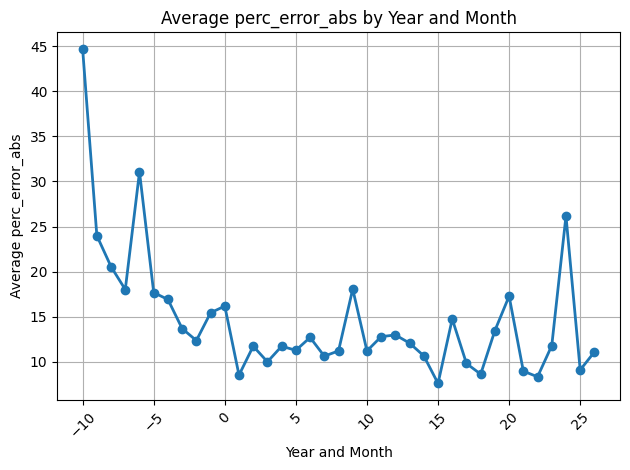

In [5]:
X_test_eval.groupby('relative_month_number').mean()['perc_error_abs'].plot(kind='line', marker='o', linestyle='-', linewidth=2, markersize=6)

plt.title('Average perc_error_abs by Year Month')  # Title of the plot
plt.xlabel('Year and Month')  # X-axis label
plt.ylabel('Average perc_error_abs')  # Y-axis label
plt.grid(True)  # Show grid
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

plt.show()

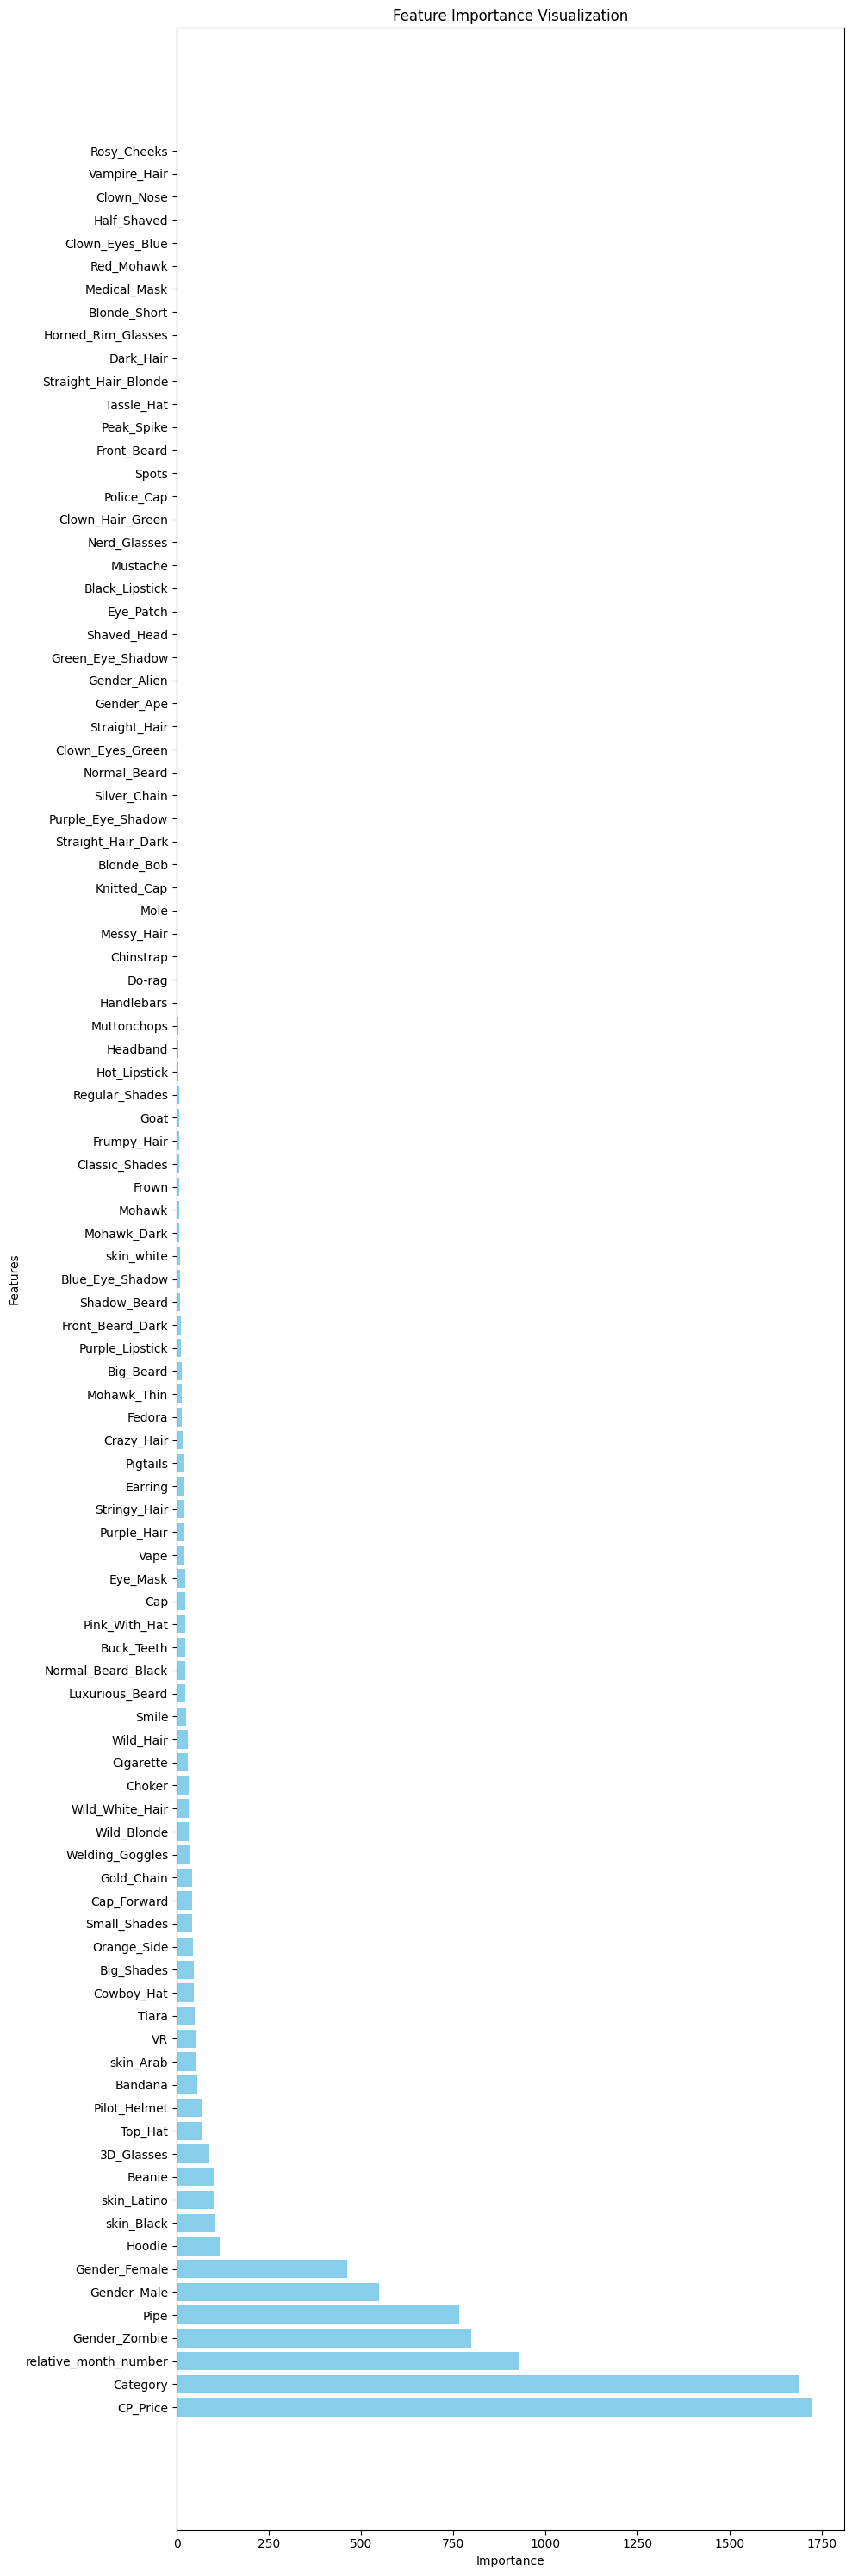

In [6]:
# Get feature importance
importance = bst.feature_importance()

# Get feature names
feature_names = bst.feature_name()

# Create a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature Name': feature_names,
    'Importance': importance
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# Creating the plot
plt.figure(figsize=(10, 30))
plt.barh(feature_importance_df['Feature Name'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance Visualization')
plt.tight_layout()

# Show the plot
plt.show()

CP Price
Category
Front Beard Dark
VR
Clown Eyes Green
Buck Teeth
Wild Hair
Silver Chain
Cigarette
Purple Eye Shadow
Pigtails
Handlebars
Normal Beard
Blonde Bob
Muttonchops
Smile
Shaved Head
Mustache
Mohawk Dark
Straight Hair
Choker
Regular Shades
Peak Spike
Tassle Hat
Dark Hair
Knitted Cap
Bandana
Pink With Hat
Gold Chain
Mohawk
Welding Goggles
Cap Forward
Tiara
Purple Lipstick
Small Shades
Stringy Hair
Do-rag
Wild White Hair
Frown
Red Mohawk
Half Shaved
Clown Hair Green
Vampire Hair
Beanie
Clown Nose
Messy Hair
Blonde Short
Mole
Purple Hair
Chinstrap
Orange Side
Hot Lipstick
Horned Rim Glasses
Cap
Green Eye Shadow
Nerd Glasses
Rosy Cheeks
Pilot Helmet
Straight Hair Dark
Medical Mask
Frumpy Hair
Wild Blonde
Hoodie
Earring
Big Shades
Spots
Headband
Goat
Big Beard
Classic Shades
Clown Eyes Blue
Blue Eye Shadow
Cowboy Hat
Luxurious Beard
Crazy Hair
Normal Beard Black
Fedora
Straight Hair Blonde
Vape
Mohawk Thin
Front Beard
3D Glasses
Police Cap
Top Hat
Shadow Beard
Eye Mask
Black Lipstic

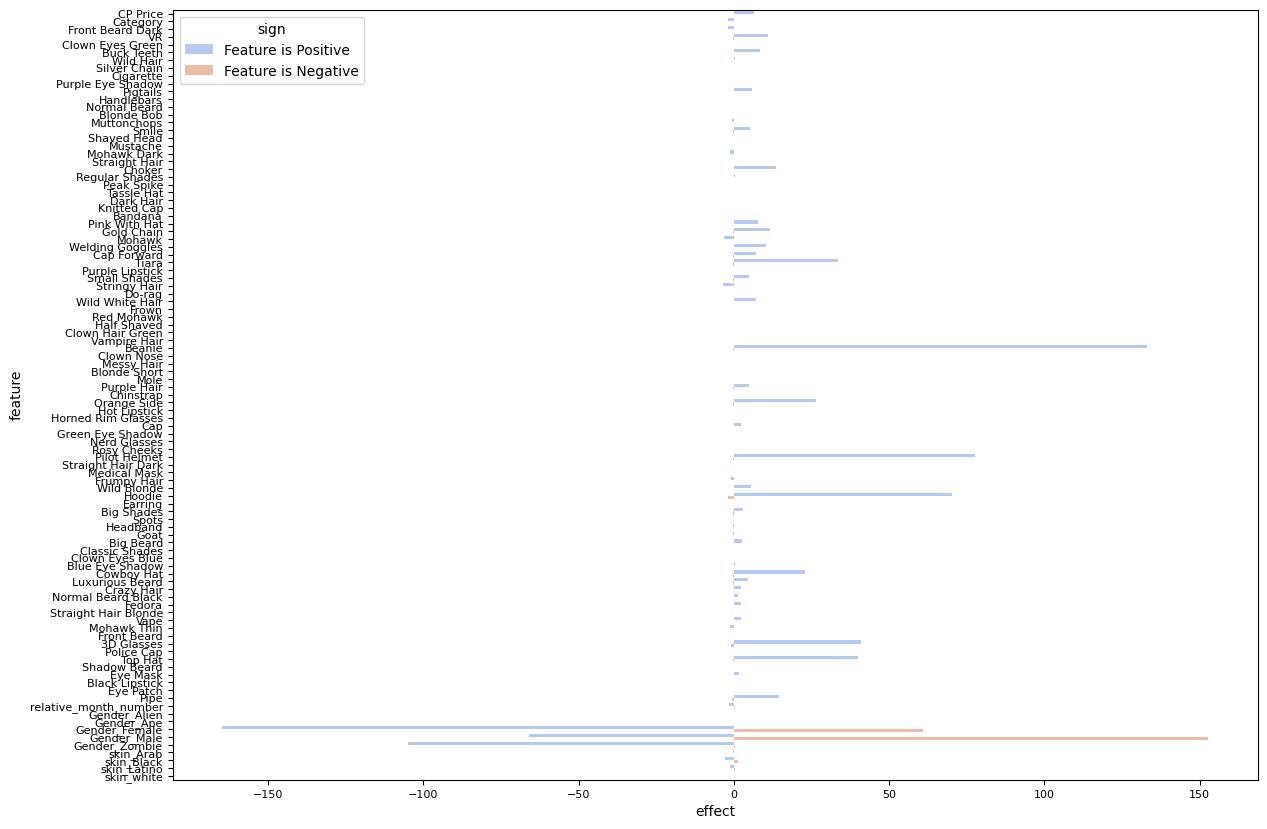

In [8]:
# Explainable AI
chosen_model = bst  

# Explain the model with SHAP
explainer_cv = shap.TreeExplainer(chosen_model)
shap_values_cv = explainer_cv.shap_values(X_test)

try:
    shap_df_cv = pd.DataFrame(shap_values_cv[1], columns=X_test.columns)
except:
    #for xgboost
    shap_df_cv = pd.DataFrame(shap_values_cv, columns=X_test.columns)

shap.initjs()



X_test_shap = X_test.copy()
X_test_shap.columns = X_test_shap.columns+"_value"
shap_df_cv_feature_values = pd.concat([shap_df_cv.reset_index(drop=True), X_test_shap.reset_index(drop=True)], axis=1)

# Append the SHAP values to the aggregate DataFrame
shap_aggregate = shap_df_cv
all_y_test_cv = y_test

shap_aggregate_feature_values = shap_df_cv_feature_values
mean_shap_values = shap_aggregate.mean()

all_y_test_cv.columns = ['y']

manual_effects = pd.DataFrame()

for i, column in enumerate(X_test.columns):
   print(column)

   effects_feature = pd.concat([shap_aggregate_feature_values[[f'{column}', f'{column}_value']].reset_index(drop=True), all_y_test_cv.reset_index(drop=True)], axis=1)
   m_effects = pd.DataFrame()
   m_effects.loc[0, 'feature'] = column
   m_effects.loc[0, 'sign'] = 'Feature is Positive'
   m_effects.loc[0, 'effect'] = effects_feature[effects_feature[f'{column}_value'] >=1][column].median()
   manual_effects =pd.concat([manual_effects, m_effects], axis=0)
   
   m_effects = pd.DataFrame()
   m_effects.loc[0, 'feature'] = column
   m_effects.loc[0, 'sign'] = 'Feature is Negative'
   m_effects.loc[0, 'effect'] =effects_feature[effects_feature[f'{column}_value'] ==0][column].median()
   manual_effects =pd.concat([manual_effects, m_effects], axis=0)


plt.figure(figsize=(14, 10))

sns.barplot(x='effect', y='feature', hue='sign', data=manual_effects, palette='coolwarm')
plt.tick_params(axis='y', labelsize=8)

plt.tick_params(labelsize=8)